In [0]:
def dataset_download_organise_gdrive():
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd "gdrive/My Drive"
  %cd 'Capstone data'
  !wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/Annotations_Train_mscoco.zip
  !wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/Questions_Train_mscoco.zip
  !wget http://images.cocodataset.org/zips/train2014.zip
  !unzip Annotations_Train_mscoco.zip -d train
  !unzip Questions_Train_mscoco.zip -d train
  !unzip train2014.zip -d train

{}

In [2]:
import tensorflow as tf
from tqdm import tqdm_notebook as tqdm
import time

from vqa import VQA
import nltk
import os
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import pandas as pd
import numpy as np
#nltk.download('punkt')

In [3]:
from keras import backend as K
from keras.engine import Layer

Using TensorFlow backend.


In [4]:
import keras 
global graph,model
graph = tf.get_default_graph()

In [5]:
sess = tf.Session()
K.set_session(sess)

In [6]:
tf.__version__

'1.13.1'

# Text and Image Processing for train data

### Text Processing

This is where the VQA images question and answers are filtered, taken into memory.

In [7]:
from sklearn.preprocessing import LabelEncoder
#enc = OneHotEncoder(handle_unknown='ignore')
label_encoder = LabelEncoder()

def text_processing(questions_file,answers_file,data_type,my_annotation_file):
  
    if os.path.exists(my_annotation_file):
        print("annotations found")
        annotations=pd.read_csv(my_annotation_file)
    else:
        train_answer_file = "./train/mscoco_train2014_annotations.json"
        train_question_file = "./train/MultipleChoice_mscoco_train2014_questions.json",
        vqa = VQA("./train/mscoco_train2014_annotations.json" , "./train/MultipleChoice_mscoco_train2014_questions.json")
        vqa.filter_by_ques_len(30)
        vqa.filter_by_ans_len(10)
        
        question_ids = vqa.getQuesIds(ansTypes="yes/no")
        
        answer_types = [vqa.qa[k]['answer_type'] for k in question_ids]
        image_ids = [vqa.qa[k]['image_id'] for k in question_ids]
        image_files = [os.path.join("./train/train2014", "COCO_train2014"+"_000000"+("%06d" %k)+".jpg")
                       for k in image_ids]
        questions = [vqa.qqa[k]['question'] for k in question_ids]
        answers = [vqa.qa[k]['best_answer'] for k in question_ids]
          
  
  
        annotations = pd.DataFrame({'question_id': question_ids,
                                    'image_id': image_ids,
                                    'image_file': image_files,
                                    'question': questions,
                                    'answer': answers,
                                     'answer_type':answer_types})
        annotations.to_csv(my_annotation_file)
  


    #   all_answers = []
    #   for answer in annotations["answer"]:
    #     ans = "<start> " + answer + " <end>"
    #     all_answers.append(ans)

#     top_k = 5000
#     tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, 
#                                                   oov_token="<unk>", 
#                                                   filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

#     tokenizer.fit_on_texts(all_captions)
#     tokenizer.word_index['<pad>'] = 0
#     train_seqs = tokenizer.texts_to_sequences(all_captions)
#     questions_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

#     answer_vector = np.expand_dims(annotations["answer"],axis =1)
#     #answer_vector = np.reshape(annotations["answer"],(-1,1))
#     print(answer_vector)
    #   answer_vector = tokenizer.texts_to_sequences(all_answers)
    #   answer_vector=tf.keras.preprocessing.sequence.pad_sequences(answer_vector, padding='post')
    
#     tokenizer2 = tf.keras.preprocessing.text.Tokenizer(num_words=3, 
#                                                   oov_token="<unk>", 
#                                                   filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
#     tokenizer2.fit_on_texts(annotations["answer"])
#     answer_vector =  tokenizer2.texts_to_sequences(annotations["answer"])
#     answer_vector= enc.fit_transform(answer_vector).toarray()
    
    questions_vector = annotations["question"]
    answer_vector = []
    for i in annotations["answer"]:
        if i == "yes":
            answer_vector.append(1)
        else:
            answer_vector.append(0)
            
    
    image_name_vector = list(annotations["image_file"])
    questions_vector = np.array(questions_vector)
    image_name_vector = list(image_name_vector)
    
    print(len(image_name_vector))
    print(len(questions_vector))
    print(image_name_vector[:2])
    
    return image_name_vector,questions_vector,answer_vector
  
image_name_vector,questions_vector,answer_vector = text_processing("./train/mscoco_train2014_annotations.json",
                                                                            "./train/MultipleChoice_mscoco_train2014_questions.json",
                                                                            "./train/train2014","./train/my_mcq_annotation_file")


  

annotations found
95163
95163
['./train/train2014/COCO_train2014_000000487025.jpg', './train/train2014/COCO_train2014_000000078077.jpg']


# Displaying the parameters

In [8]:

# questions_vector = np.array(questions_vector)
# image_name_vector = list(image_name_vector)

print(len(answer_vector))
print(len(image_name_vector))
print(len(questions_vector))
print(type(image_name_vector))
print(type(questions_vector))
print(type(answer_vector))
print(questions_vector[1:3])
print(image_name_vector[1:3])
print(answer_vector[34])
print((answer_vector[:10]))



95163
95163
95163
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>
['is this a modern train'
 'is the bus driver on any kind of antidepressant medication']
['./train/train2014/COCO_train2014_000000078077.jpg', './train/train2014/COCO_train2014_000000501867.jpg']
1
[1, 0, 0, 1, 1, 0, 1, 1, 0, 1]


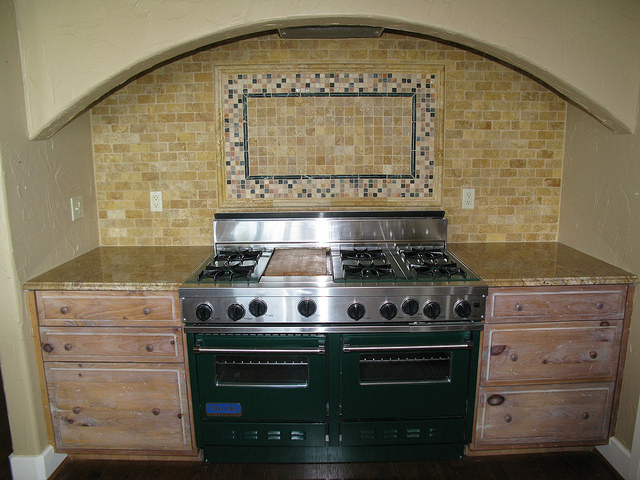

In [9]:
from IPython.display import display, Image
display(Image(filename=image_name_vector[37]))


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
print("\t\t\t Total Records")
print("The total no of answers\t\t\t" ,len(answer_vector))
print("The total no of images\t\t\t" ,len(answer_vector))
print("The total no of questions\t\t" ,len(answer_vector))

			 Total Records
The total no of answers			 95163
The total no of images			 95163
The total no of questions		 95163


In [16]:
annotations=pd.read_csv("./train/my_mcq_annotation_file")

In [14]:
from pprint import pprint 
print("5 random questions and answers to it ")
new_dict = annotations[50:55]["question"]
print(new_dict.to_list())
#print(annotations[new_dict])
print("\nTheir respective answers")
new_dict = annotations[50:55]["answer"]
print(new_dict.to_list())

5 random questions and answers to it 
['is it storming outside', 'is the woman in the middle the mom of the two boys', 'are they all in college', 'is this a pizza', 'does the person who ordered this pizza like red sauce']

Their respective answers
['no', 'yes', 'no', 'yes', 'no']


In [15]:
print(annotations.sample(5))

       Unnamed: 0  question_id  image_id  \
47153       47153       388270     38827   
5401         5401      4770152    477015   
232           232      1905800    190580   
58224       58224      5338030    533803   
37430       37430       595730     59573   

                                              image_file  \
47153  ./train/train2014/COCO_train2014_000000038827.jpg   
5401   ./train/train2014/COCO_train2014_000000477015.jpg   
232    ./train/train2014/COCO_train2014_000000190580.jpg   
58224  ./train/train2014/COCO_train2014_000000533803.jpg   
37430  ./train/train2014/COCO_train2014_000000059573.jpg   

                                    question answer answer_type  
47153                          is this a dog    yes      yes/no  
5401                is this a two-way street     no      yes/no  
232                       is this cat asleep     no      yes/no  
58224           is the brown animal a female    yes      yes/no  
37430  does the meat in the pan look healthy

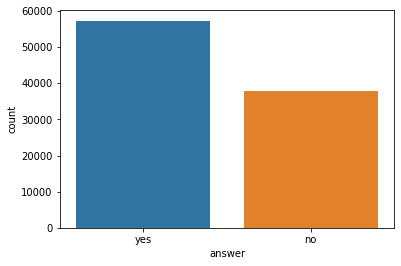

In [17]:
sns.countplot(data=annotations,x='answer')

In [18]:
annotations["question_len"] = [len(q) for q in annotations["question"]]

In [19]:
yes_ques_len = []
no_ques_len = []
for a in annotations["answer"] :
    if  a == "yes":
        yes_ques_len.append(annotations["question_len"])
    if a =="no":
        no_ques_len.append(annotations["question_len"])
        

In [20]:
print(len(yes_ques_len))

57329


# Image preprocessing for Train data

In [59]:
greater_than_299 =np.empty((2,))
lesser_than_299 = np.empty((2,))
mean_of_size = np.empty((2,400,3))

#mean_of_size_no = np.empty((2,400,3))
import imageio

from matplotlib.image import imread

def img_calc_size(img):
    
    img = imageio.imread(img)
    
    yield img

In [60]:
sample_answer_yes = []
sample_answer_no = []
for i,ans in enumerate(answer_vector):
    if(ans == 1):
        sample_answer_yes.append(i)
    if(ans == 0):
        sample_answer_no.append(i)
       
    

In [61]:
sampled_image_names = np.array(image_name_vector)
sampled_image_names_yes=list(sampled_image_names[np.random.choice(sample_answer_yes, 400, replace=False)])
sampled_image_names_no=list(sampled_image_names[np.random.choice(sample_answer_no, 400, replace=False)])

In [62]:
print(len(sampled_image_names_yes))

400


In [63]:
def calculate_img_analsys(sampled_image_names,typ):
    
    for i,sam in enumerate(sampled_image_names) :
        img = img_calc_size(sam).__next__()
        if(img.shape[0] > 299 and img.shape[1] > 299 ):
            
            greater_than_299[typ] = greater_than_299[typ]+ 1
        elif(img.shape[0] < 299 and img.shape[1] < 299 ):
            lesser_than_299[typ] = lesser_than_299[typ]+1
        mean_of_size[typ][i] =  np.mean(img,axis =(0,1))
    
     
    

In [64]:
calculate_img_analsys(sampled_image_names_yes,1)
calculate_img_analsys(sampled_image_names_no,0)

In [66]:
print("The RGB mean values for No answers\t\t\t{0}".format(np.mean(mean_of_size[0],axis=(0))))
print("The RGB mean values for Yes answers\t\t\t{0}".format(np.mean(mean_of_size[1],axis=(0))))
print("The RGB std values for No answers\t\t\t{0}".format(np.std(mean_of_size[0],axis=(0))))
print("The RGB std values for Yes answers\t\t\t{0}".format(np.std(mean_of_size[1],axis=(0))))

# print("No of images with size lesser than 299 for Yes answers\t\t\t{0}".format(lesser_than_299[1]))
# print("No of images with size greater than 299 for Yes answers\t\t\t{0}".format(greater_than_299[1]))
# print("No of images with size lesser than 299 for no answers\t\t\t{0}".format(lesser_than_299[0]))
# print("No of images with size greater than 299 for no answers\t\t\t{0}".format(greater_than_299[0]))

The RGB mean values for No answers			[117.71135342 112.0535665  102.52564799]
The RGB mean values for Yes answers			[118.7029844  112.96209297 103.72230445]
The RGB std values for No answers			[32.91562039 33.44795909 38.87515253]
The RGB std values for Yes answers			[31.72024538 31.7075329  36.72497776]


The following piece of code is required to extract features from the images through the InceptionV3 module.

In [121]:
# image_model = tf.keras.applications.InceptionV3(include_top=False, 
#                                                 weights='imagenet')
# new_input = image_model.input
# hidden_layer = image_model.layers[-1].output

# image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


In [122]:
# def load_image_1(image_path):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, (299, 299))
#     img = tf.keras.applications.inception_v3.preprocess_input(img)
#     return img, image_path

## Image conversion to .npy files
The below code builds numpy files of the image files. The image files are passed through an existing inception model to obtain features which are then saved as a numpy file with ".npy" added to the name of the image.
The code is commented because the image conversion is needed only once. After that we can access those numpy files 

In [123]:
# feel free to change the batch_size according to your system configuration

# image_dataset = tf.data.Dataset.from_tensor_slices(
#                                 image_name_vector[:n_train_samples]).map(load_image_1).batch(16)

# for img, path in tqdm(image_dataset):
#     batch_features = image_features_extract_model(img)
#     batch_features = tf.reshape(batch_features, 
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#     for bf, p in zip(batch_features, path):
#         path_of_feature = p.numpy().decode("utf-8")
#         np.save(path_of_feature, bf.numpy())

The following codes removes all the numpy files created by the previous cell in the train/train2014/ folder. So that  we can create new numpy files again.

In [124]:
# cou = 0
# import os, shutil
# folder = './train/train2014/'
# for the_file in os.listdir(folder):
#     file_path = os.path.join(folder, the_file)
#     try:
#         if os.path.isfile(file_path) :
#             print(file_path)
#             if file_path.__contains__(".npy"):
#                 print("found")
#                 cou += 1
#                 os.unlink(file_path)
#         #elif os.path.isdir(file_path): shutil.rmtree(file_path)
#     except Exception as e:
#         print(e)


In [125]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

units = 512
# vocab_size = len(tokenizer.word_index)
# shape Tof the vector extracted from InceptionV3 is (64, 2048)
# these two variables represent that
# features_shape = 2048
# attention_features_shape = 64
# LOG_FREQ = 18
# SAVE_FREQ = 2


This function maps the image path to its numpy file

In [126]:
def map_func(img_name, ques):
    img_tensor = np.load(img_name.numpy().decode('utf-8')+'.npy')
    #print(img_tensor)
    #img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, ques

In [127]:
# def load_image_2(image_path,cap,answer_vector):
#     img = tf.io.read_file(image_path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, (299, 299))
#     img = tf.keras.applications.inception_v3.preprocess_input(img)
#     img = tf.expand_dims(img,0)
#     img = image_features_extract_model(img)
#     img = tf.reshape(img, (-1, img.shape[3]))
#     return img,cap,answer_vector


In [151]:
image_name_vector2 = image_name_vector[:n_train_samples]
questions_vector2= questions_vector[:n_train_samples]
answer_vector2 = answer_vector[:n_train_samples]

Data is split into test and train

In [152]:
img_name_train, img_name_val, ques_train, ques_val, answer_train,answer_val = train_test_split(image_name_vector2,questions_vector2,answer_vector2,
                                                                    test_size=0.2, 
                                                                    random_state=0)

Tf.data is constructed for train setfrom the numpy values of the images.

In [153]:
dataset_d1 = tf.data.Dataset.from_tensor_slices((img_name_train,ques_train))
dataset_d2 = tf.data.Dataset.from_tensor_slices(answer_train)
dataset_d1 = dataset_d1.map(lambda item1, item2: tf.py_function(map_func, [item1, item2], [tf.float32, tf.string]), num_parallel_calls=1)
#dataset_d1 = dataset_d1.map(map_func)
dataset = tf.data.Dataset.zip((dataset_d1,dataset_d2))

# using map to load the numpy files in parallel
# NOTE: Be sure to set num_parallel_calls to the number of CPU cores you have
# https://www.tensorflow.org/api_docs/python/tf/py_func
#dataset = dataset.map(lambda item1, item2,item3: tf.py_function(map_func, [item1, item2,item3], [tf.float32, item2.dtype,item3.dtype]), num_parallel_calls=1)
#dataset  =dataset.map(load_image)
# shuffling and batching
dataset = dataset.shuffle(BUFFER_SIZE).repeat()
# https://www.tensorflow.org/api_docs/python/tf/contrib/data/batch_and_drop_remainder
dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)
dataset = dataset.prefetch(3)

Validation dataset to evaluate data is constructed from the image_name,question,answer of the sample. The data type passed is string,string,int.

In [154]:
val_dataset_d1 = tf.data.Dataset.from_tensor_slices((img_name_val,ques_val))
val_dataset_d2 = tf.data.Dataset.from_tensor_slices(answer_val)
val_dataset_d1 = val_dataset_d1.map(lambda item1, item2: tf.py_function(map_func, [item1, item2], [tf.float32, tf.string]), num_parallel_calls=1)
val_dataset = tf.data.Dataset.zip((val_dataset_d1,val_dataset_d2))
#val_dataset_d1 = val_dataset_d1.map(map_func)
# using map to load the numpy files in parallel
# NOTE: Be sure to set num_parallel_calls to the number of CPU cores you have
# https://www.tensorflow.org/api_docs/python/tf/py_func
#dataset = dataset.map(lambda item1, item2,item3: tf.py_function(map_func, [item1, item2,item3], [tf.float32, item2.dtype,item3.dtype]), num_parallel_calls=1)
#dataset  =dataset.map(load_image)
# shuffling and batching
val_dataset = val_dataset.shuffle(BUFFER_SIZE).repeat()
# https://www.tensorflow.org/api_docs/python/tf/contrib/data/batch_and_drop_remainder
val_dataset = val_dataset.batch(BATCH_SIZE,drop_remainder=True)
val_dataset = val_dataset.prefetch(3)

# Model Construction
The model is constructed inside a function to be called and creatd.
Notice the elmo layer is defined inside the function

In [155]:
 
class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable=False
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.elmo = hub.Module("module/module_elmo2", trainable=self.trainable,
                               name="{}_module".format(self.name))

        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)

    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['elmo']
        return result

    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[0], self.dimensions)

In [160]:

# from tensorflow.python.keras.models import Sequential

# from tensorflow.python.keras import layers
 
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import LSTM, Embedding,concatenate, Dense, TimeDistributed, Dropout, Bidirectional, Lambda,GlobalAveragePooling1D


num_hidden_units_mlp = 1024
num_hidden_units_lstm = 512
img_dim = 4096
embedding_dim = 300
# vocab_size = len(tokenizer.word_index)


def build_model():
    
    
    class ElmoEmbeddingLayer(Layer):
        def __init__(self, **kwargs):
            self.dimensions = 1024
            self.trainable=False
            super(ElmoEmbeddingLayer, self).__init__(**kwargs)

        def build(self, input_shape):
            self.elmo = hub.Module("module/module_elmo2", trainable=self.trainable,
                                   name="{}_module".format(self.name))

            self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
            super(ElmoEmbeddingLayer, self).build(input_shape)

        def call(self, x, mask=None):
            result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                          as_dict=True,
                          signature='default',
                          )['elmo']
            return result

        def compute_mask(self, inputs, mask=None):
            return K.not_equal(inputs, '--PAD--')

        def compute_output_shape(self, input_shape):
            return (input_shape[0],input_shape[0], self.dimensions)
    
    input1 = Input(shape=(64,2048),name="input_1")
    input2 = Input(shape=(1,),name="input_2",dtype="string")
    image_model = GlobalAveragePooling1D()(input1)
    #image_model.add(Dense(img_dim,activation='relu', input_shape=image_name_vector[1:]))
    #image_model = tf.keras.layers.Dense(img_dim,activation = 'relu',kernel_initializer='uniform')(input1)

    # language_model = LSTM(output_dim = num_hidden_units_lstm, 
    #     return_sequences=False, 
    #     input_shape=(max_len, word_vec_dim))(input2)
    embedding = ElmoEmbeddingLayer()(input2)
    #language_model = tf.keras.layers.Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],trainable=False)(input2)
    language_model = Bidirectional(LSTM(num_hidden_units_lstm,
                            return_sequences = True, recurrent_initializer='glorot_uniform'))(embedding)
    language_model = LSTM(num_hidden_units_lstm,
                            recurrent_initializer='glorot_uniform')(language_model)
    #language_model = tf.keras.layers.Dense()(language_model)

    language_model= concatenate([image_model,language_model])
    #model = tf.keras.layers.Concatenate(axis=1)([image_model,language_model])
    language_model = Dense(num_hidden_units_mlp, kernel_initializer="uniform",activation='tanh')(language_model)

    language_model = Dropout(0.5)(language_model)
    language_model = Dense(num_hidden_units_mlp, kernel_initializer="uniform",activation='tanh')(language_model)

    language_model = Dropout(0.5)(language_model)
    output = Dense(2,activation="softmax")(language_model)

    

    # model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    model = Model(inputs = [input1,input2],outputs = output)
    #model.summary()
    return model
#model = build_model()

These are the generators that build the data from the datasets. These generators are given to the fit_generators to fit

In [161]:
def gen():
    with tf.Session() as sess:
    
        iterator= dataset.make_one_shot_iterator()
        next_x,next_y = iterator.get_next()
        while True:
            x_batch = sess.run(next_x)
            y_batch = sess.run(next_y)
            yield ([x_batch[0],x_batch[1]],y_batch)
            #yield (x_batch,y_batch)

def val_gen():
    with tf.Session() as sess:
        iterator= val_dataset.make_one_shot_iterator()
        next_x,next_y = iterator.get_next()
        while True:
            x_batch = sess.run(next_x)
            y_batch = sess.run(next_y)
            #yield (x_batch, y_batch)
            yield ([x_batch[0],x_batch[1]],y_batch)
            


In [134]:
print(g_temp[0])

#print(g_temp[1])

[array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.3955916 , 0.        , 0.        , ..., 0.        ,
         0.16439717, 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.36607197, 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.88396007],
        [1.812484  , 0.        , 0.        , ..., 0.        ,
         0.        , 2.0630972 ],
        [2.831175  , 0.        , 0.2266205 , ..., 0.        ,
         0.        , 3.2093868 ]],

       [[0.11152001, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.23732728, 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.37415388, 0.89711106, 0.        , ..., 0.        ,
         0.52113646, 0.        ],
        ...,
        [0.        , 0.4005213 , 1.1658834 , ..., 0.        ,
         0.        , 0.        ],
        [0.

In [135]:
tf.keras.utils.plot_model(model,to_file="elmo_lstm.png",show_shapes=True)

# Compilation
The callbacks are declared 
1.Model checkpoint is declard to save all weights.
2.Early stopping is emplyed to avoid over fitting, with patiences of about 7
3.Tensorboards is declared to print the metrics at the rate of 350 batches


In [162]:
model = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0614 11:59:29.537476 140072299214656 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [163]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
elmo_embedding_layer_11 (ElmoEm (None, None, 1024)   4           input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 64, 2048)     0                                            
__________________________________________________________________________________________________
bidirectional_9 (Bidirectional) (None, None, 1024)   6295552     elmo_embedding_layer_11[0][0]    
__________________________________________________________________________________________________
global_ave

In [137]:

    


filepath = "./models/lstm_elmo_2/model-ep{epoch:03d}-loss{val_loss:.3f}.h5"
checkpoint_call_back = keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss',verbose=1,save_best_only=False,mode='min',
                                                                    period=1)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=False)

ten_call_back = keras.callbacks.TensorBoard(
    log_dir='./logs/lstm_elmo_2',
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq = 64*350 )  # How often to write logs (default: once per epoch)
model.compile(loss='sparse_categorical_crossentropy',
          optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False),
          metrics=['accuracy'])

# Execution


These class weights help in reducing the overfitting

In [138]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(answer_train),
                                                 answer_train)

In [139]:
print(class_weights)

[1.2617799  0.82817878]


Put the model name inside load_weights and execute the code

In [140]:
#model.load_weights()

The model is fit in here with 500 steps per epoch and 75 validation step per epoch

In [141]:
history = model.fit_generator(gen() ,steps_per_epoch=500,validation_data = val_gen(),validation_steps = 75,epochs = 3 ,class_weight=class_weights,callbacks=[ten_call_back,checkpoint_call_back,early_stop],verbose=1)

Epoch 1/3


W0614 11:29:48.429820 140064822654720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f633848a7b8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), (64,)), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 11:29:48.432106 140064008939264 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6338490518>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), (64,)), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 11:29:48.435699 140064822654720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f633848a7b8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), (64,)), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 11:29:48.440442 140064008939264 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6338490518>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), (64,)), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.
W0614 11:29:48.443395 140064822654720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f633848a7b8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, 

W0614 11:29:48.447744 140064008939264 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6338490518>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), ()), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.
W0614 11:29:48.450067 140064822654720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f633848a7b8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <un

W0614 11:29:48.453981 140064008939264 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6338490518>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), ()), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.
W0614 11:29:48.457469 140064822654720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f633848a7b8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <un

W0614 11:29:48.460417 140064008939264 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6338490518>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), ()), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 11:29:48.462321 140064822654720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f633848a7b8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: (<unknown>, <unknown>), types: (tf.float32, tf.string)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 11:29:48.466353 140064008939264 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6338490518>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: (<unknown>, <unknown>), types: (tf.float32, tf.string)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.
W0614 11:29:48.470100 140064822654720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f633848a7b8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: (), types: tf.int32> was created i

W0614 11:29:48.473881 140064008939264 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6338490518>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: (), types: tf.int32> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 11:29:48.477489 140064822654720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f633848a7b8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 11:29:48.480704 140064008939264 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6338490518>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


250/500 [==============>...............] - ETA: 14:44 - loss: 1.0602 - acc: 0.5377

KeyboardInterrupt: 

In [101]:
model.save_weights("./models/lstm_elmo_new/epoch1.h5")

# Model evaluation 
 The model is evaluated on random data from the dataset.

In [75]:
metrics = model.evaluate_generator(val_gen(),steps = 125,verbose=1)

W0614 08:25:13.716912 140066550695680 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6474655cf8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), (64,)), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 08:25:13.727127 140066550695680 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6474655cf8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), (64,)), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 08:25:13.730877 140066550695680 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6474655cf8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), ()), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 08:25:13.734564 140066550695680 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6474655cf8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), ()), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 08:25:13.739134 140066550695680 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6474655cf8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), ()), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 08:25:13.742048 140066550695680 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6474655cf8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: (<unknown>, <unknown>), types: (tf.float32, tf.string)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 08:25:13.745146 140066550695680 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6474655cf8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: (), types: tf.int32> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 08:25:13.748372 140066550695680 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f6474655cf8>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


125/125 [==============================] - 398s 3s/step


Exception ignored in: <generator object val_gen at 0x7f64745a9780>
Traceback (most recent call last):
  File "<ipython-input-28-e0815565c266>", line 20, in val_gen
  File "/home/paperspace/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1587, in __exit__
    self._default_graph_context_manager.__exit__(exec_type, exec_value, exec_tb)
  File "/usr/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/paperspace/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 5257, in get_controller
    context.context().context_switches.pop()
  File "/home/paperspace/.local/lib/python3.6/site-packages/tensorflow/python/eager/context.py", line 199, in pop
    self.stack.pop()
IndexError: pop from empty list


validation loss and accuracy

In [76]:
print(metrics)

[2.1437105293273926, 0.60275]


# Graphs on accuracy and loss

The loss and accuracy displayed here are for epoch 1 to 8

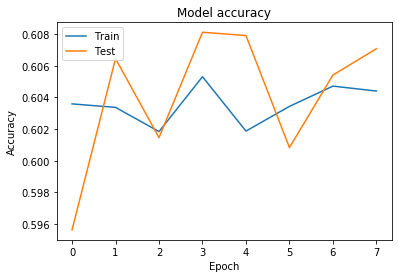

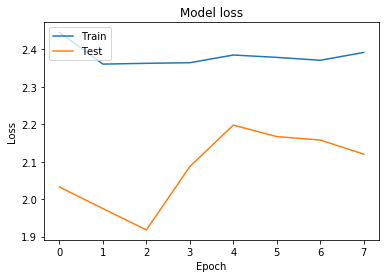

In [91]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The accuracy and loss of epoch 8 to 16

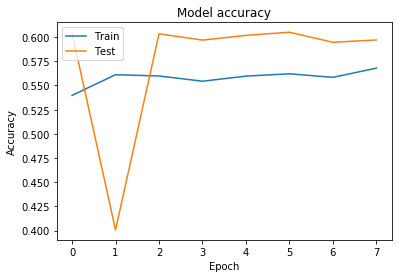

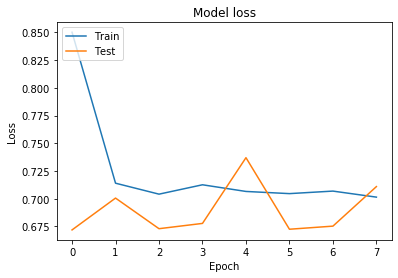

In [43]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [85]:
preds = model.predict_generator(val_gen(),steps=20,verbose=1)

W0614 08:41:03.723470 140067018622720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f64745ad8d0>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), (64,)), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 08:41:03.732605 140067018622720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f64745ad8d0>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), (64,)), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 08:41:03.735259 140067018622720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f64745ad8d0>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), ()), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 08:41:03.739579 140067018622720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f64745ad8d0>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), ()), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 08:41:03.743271 140067018622720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f64745ad8d0>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((<unknown>, <unknown>), ()), types: ((tf.float32, tf.string), tf.int32)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 08:41:03.746503 140067018622720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f64745ad8d0>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: (<unknown>, <unknown>), types: (tf.float32, tf.string)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 08:41:03.749138 140067018622720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f64745ad8d0>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: (), types: tf.int32> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


W0614 08:41:03.752606 140067018622720 dataset_ops.py:1662] The graph (<tensorflow.python.framework.ops.Graph object at 0x7f64745ad8d0>) of the iterator is different from the graph (<tensorflow.python.framework.ops.Graph object at 0x7f64bfebaf28>) the dataset: <DatasetV1Adapter shapes: ((), ()), types: (tf.string, tf.string)> was created in. If you are using the Estimator API, make sure that no part of the dataset returned by the `input_fn` function is defined outside the `input_fn` function.Please ensure that all datasets in the pipeline are created in the same graph as the iterator. NOTE: This warning will become an error in future versions of TensorFlow.


20/20 [==============================] - 71s 4s/step


Exception ignored in: <generator object val_gen at 0x7f64745a9ba0>
Traceback (most recent call last):
  File "<ipython-input-28-e0815565c266>", line 20, in val_gen
  File "/home/paperspace/.local/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1587, in __exit__
    self._default_graph_context_manager.__exit__(exec_type, exec_value, exec_tb)
  File "/usr/lib/python3.6/contextlib.py", line 99, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/paperspace/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 5257, in get_controller
    context.context().context_switches.pop()
  File "/home/paperspace/.local/lib/python3.6/site-packages/tensorflow/python/eager/context.py", line 199, in pop
    self.stack.pop()
IndexError: pop from empty list


# Prediction

In [37]:
tf.reset_default_graph()
K.clear_session()

Inception features are extracted from the image

In [23]:
#del image_mod

image_mod = tf.keras.applications.InceptionV3(include_top=False, 
                                             weights='imagenet')
new_input_o = image_mod.input
hidden_lay = image_mod.layers[-1].output

image_features_ex = tf.keras.Model(new_input_o, hidden_lay)


Instructions for updating:
Colocations handled automatically by placer.


W0613 21:13:21.749707 140377936537408 deprecation.py:323] From /home/paperspace/.local/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [51]:
img = "./train/train2014/COCO_train2014_000000250597.jpg"
que = "is this girl's hair a natural color"

In [52]:
def image_conv(image_path):
    
    #tf.reset_default_graph()
    img_1 = tf.io.read_file(image_path)
    img_1 = tf.image.decode_jpeg(img_1, channels=3)
    img_1 = tf.image.resize(img_1, (299, 299))
    img_1 = tf.keras.applications.inception_v3.preprocess_input(img_1)
    img_1 = K.expand_dims(img_1,  0)
    print(img_1.shape)
    img_1 = image_features_ex_2(img_1)
    image_feat = tf.reshape(img_1,(img.shape[0], -1, img.shape[3]))
    return image_feat

In [ ]:

print(img)

img = image_conv(img)

tf.reset_default_graph()
print(img.shape)

single_q = np.expand_dims(que,0)
print(single_q.shape)


with graph.as_default():
    
    tf.global_variables_initializer()
    model = build_model()
    model.load_weights("./models/lstm_elmo/model-ep001-loss0.754.h5")
    predictions = model.predict([img,single_q],steps=64)
    K.clear_session()
        

In [ ]:
max_1 = np.argmax(predictions,axis=1)
if(max_1==0):
    print("No")
if(max_1 ==1):
    print("Yes")

In [36]:
from six.moves import cPickle as pickle #for performance
#from __future__ import print_function
import numpy as np

def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

In [38]:
save_dict(history,"./history/epoch8")
